In [123]:
import re
import spacy
import requests
import pandas as pd
from bs4 import BeautifulSoup
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [124]:
# get text from html and parse it
response = requests.get('http://www.bbc.com/news')
doc = BeautifulSoup(response.text, 'html.parser')
headlines1 = doc.find_all('h3')
stories_list = []

for headline in headlines1:
    print(headline.text)
    stories_list.append(headline.text)

# Now that we're done, convert to a CSV and save.
# If you don't use index=False, you'll get an ugly dataframe!
import pandas as pd
df = pd.DataFrame(stories_list)
df.to_csv("bbc.csv", index=False)

Do Afghans feel differently about the Taliban now?
Do Afghans feel differently about the Taliban now?
William Ruto wins Kenya election amid drama
Lyse Doucet: From Kabul and beyond, a year of Taliban rule
Iran blames Rushdie and supporters for stabbing
Shanghai Ikea shoppers flee Covid lockdown attempt
Ukraine hits Russian Wagner mercenary HQ in east
Tom Holland quits social media for mental health
'Just weird': Ex-Australian PM held 'secret roles'
Heche organs donated as life support switched off
UK first country to approve dual-strain Covid jab
Remote Pacific nation hit by first Covid outbreak
UK first country to approve dual-strain Covid jab
Remote Pacific nation hit by first Covid outbreak
We saved who we could - Egypt church fire survivor
Women 'disposable' to 'predator' Mendy, jury told
'Match sucked me in' - why Tuchel & Conte saw red
The Taliban's broken promises
Former Afghan leaders mark year of Taliban rule
We fled the Taliban for our Olympic dream
The librarian who defied t

In [ ]:
doc

In [126]:
stories_list

['Do Afghans feel differently about the Taliban now?',
 'Do Afghans feel differently about the Taliban now?',
 'William Ruto wins Kenya election amid drama',
 'Lyse Doucet: From Kabul and beyond, a year of Taliban rule',
 'Iran blames Rushdie and supporters for stabbing',
 'Shanghai Ikea shoppers flee Covid lockdown attempt',
 'Ukraine hits Russian Wagner mercenary HQ in east',
 'Tom Holland quits social media for mental health',
 "'Just weird': Ex-Australian PM held 'secret roles'",
 'Heche organs donated as life support switched off',
 'UK first country to approve dual-strain Covid jab',
 'Remote Pacific nation hit by first Covid outbreak',
 'UK first country to approve dual-strain Covid jab',
 'Remote Pacific nation hit by first Covid outbreak',
 'We saved who we could - Egypt church fire survivor',
 "Women 'disposable' to 'predator' Mendy, jury told",
 "'Match sucked me in' - why Tuchel & Conte saw red",
 "The Taliban's broken promises",
 'Former Afghan leaders mark year of Taliban

In [127]:
# import wikipedia sentences, they have 4318 rows
headlines = pd.read_csv("bbc.csv")
headlines.shape

(47, 1)

In [128]:
headlines

,0
0,Do Afghans feel differently about the Taliban now?
1,Do Afghans feel differently about the Taliban now?
2,William Ruto wins Kenya election amid drama
3,"Lyse Doucet: From Kabul and beyond, a year of Taliban rule"
4,Iran blames Rushdie and supporters for stabbing
5,Shanghai Ikea shoppers flee Covid lockdown attempt
6,Ukraine hits Russian Wagner mercenary HQ in east
7,Tom Holland quits social media for mental health
8,'Just weird': Ex-Australian PM held 'secret roles'
9,Heche organs donated as life support switched off


In [129]:
# exact sentence example
nlp = spacy.load('en_core_web_sm')

doc = nlp("Ukraine hits Russian Wagner mercenary HQ in east.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Ukraine ... nsubj
hits ... ROOT
Russian ... amod
Wagner ... nmod
mercenary ... amod
HQ ... dobj
in ... prep
east ... pobj
. ... punct


In [130]:
def get_entities(sent):

  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
      
   #############################################################

  return [ent1.strip(), ent2.strip()]

In [131]:
get_entities("Ukraine hits Russian Wagner mercenary HQ in east.")

['Ukraine', 'mercenary  east']

In [140]:
entity_pairs = []

In [141]:
entity_pairs[10:20]

[]

In [142]:
entity_pairs

[]

In [143]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match=None) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [144]:
# verb
get_relation("Ukraine hits Russian Wagner mercenary HQ in east.")

'hits Russian'

In [145]:
# the column name is 0
relations = [get_relation(i) for i in tqdm(headlines['0'])]

100%|██████████| 47/47 [00:00<00:00, 102.61it/s]


In [146]:
entity_pairs = []

for i in tqdm(headlines["0"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 47/47 [00:00<00:00, 113.27it/s]


In [147]:
# revise new entity pairs
entity_pairs[10:20]

[['', 'dual strain Covid jab'],
 ['', 'Covid Remote Pacific outbreak'],
 ['', 'dual strain Covid jab'],
 ['', 'Covid Remote Pacific outbreak'],
 ['We', 'who church fire survivor'],
 ['predator  jury', 'predator  Mendy'],
 ['why  Tuchel', 'red'],
 ['', ''],
 ['Afghan  leaders', 'Taliban rule'],
 ['We', 'Olympic  dream']]

In [151]:
# verb count
pd.Series(relations).value_counts()[:50]

feel              2
country           2
nation            2
performers        1
genius            1
Ibiza             1
above             1
heard             1
tech              1
partitioned       1
haunts black      1
story             1
end of            1
animals           1
politician        1
homes of          1
novel of          1
way               1
problem for       1
town              1
newsletter        1
app               1
rocks             1
defiant           1
wins              1
Radio             1
Doucet            1
blames            1
flee              1
hits Russian      1
quits social      1
weird             1
switched          1
saved             1
told              1
saw red           1
promises          1
mark              1
fled              1
librarian         1
working behind    1
wiped             1
TV                1
Get in            1
dtype: int64

In [152]:
import nltk 

In [153]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [154]:
stories_list

['Do Afghans feel differently about the Taliban now?',
 'Do Afghans feel differently about the Taliban now?',
 'William Ruto wins Kenya election amid drama',
 'Lyse Doucet: From Kabul and beyond, a year of Taliban rule',
 'Iran blames Rushdie and supporters for stabbing',
 'Shanghai Ikea shoppers flee Covid lockdown attempt',
 'Ukraine hits Russian Wagner mercenary HQ in east',
 'Tom Holland quits social media for mental health',
 "'Just weird': Ex-Australian PM held 'secret roles'",
 'Heche organs donated as life support switched off',
 'UK first country to approve dual-strain Covid jab',
 'Remote Pacific nation hit by first Covid outbreak',
 'UK first country to approve dual-strain Covid jab',
 'Remote Pacific nation hit by first Covid outbreak',
 'We saved who we could - Egypt church fire survivor',
 "Women 'disposable' to 'predator' Mendy, jury told",
 "'Match sucked me in' - why Tuchel & Conte saw red",
 "The Taliban's broken promises",
 'Former Afghan leaders mark year of Taliban

In [155]:
textsample ="Ukraine hits Russian Wagner mercenary HQ in east."  

sentences = nltk.sent_tokenize(textsample)  
words = nltk.word_tokenize(textsample)  
sentences 
[w for w in words if w.isalpha()]

['Ukraine', 'hits', 'Russian', 'Wagner', 'mercenary', 'HQ', 'in', 'east']

In [156]:
sentences

['Ukraine hits Russian Wagner mercenary HQ in east.']

In [157]:
# extract subject
source = [i[0] for i in entity_pairs]
# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [158]:
kg_df.head(5)

,source,target,edge
0,Afghans,differently Taliban,feel
1,Afghans,differently Taliban,feel
2,William Ruto,Kenya drama,wins
3,,Taliban rule,Doucet
4,Iran,Rushdie,blames


In [159]:
kg_df

,source,target,edge
0,Afghans,differently Taliban,feel
1,Afghans,differently Taliban,feel
2,William Ruto,Kenya drama,wins
3,,Taliban rule,Doucet
4,Iran,Rushdie,blames
5,Shanghai Ikea shoppers,Covid lockdown attempt,flee
6,Ukraine,mercenary east,hits Russian
7,Tom Holland,mental health,quits social
8,Australian Ex PM,secret roles,weird
9,Heche organs,life support,switched


In [ ]:
# Make a search with the Wikipedia API

In [160]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

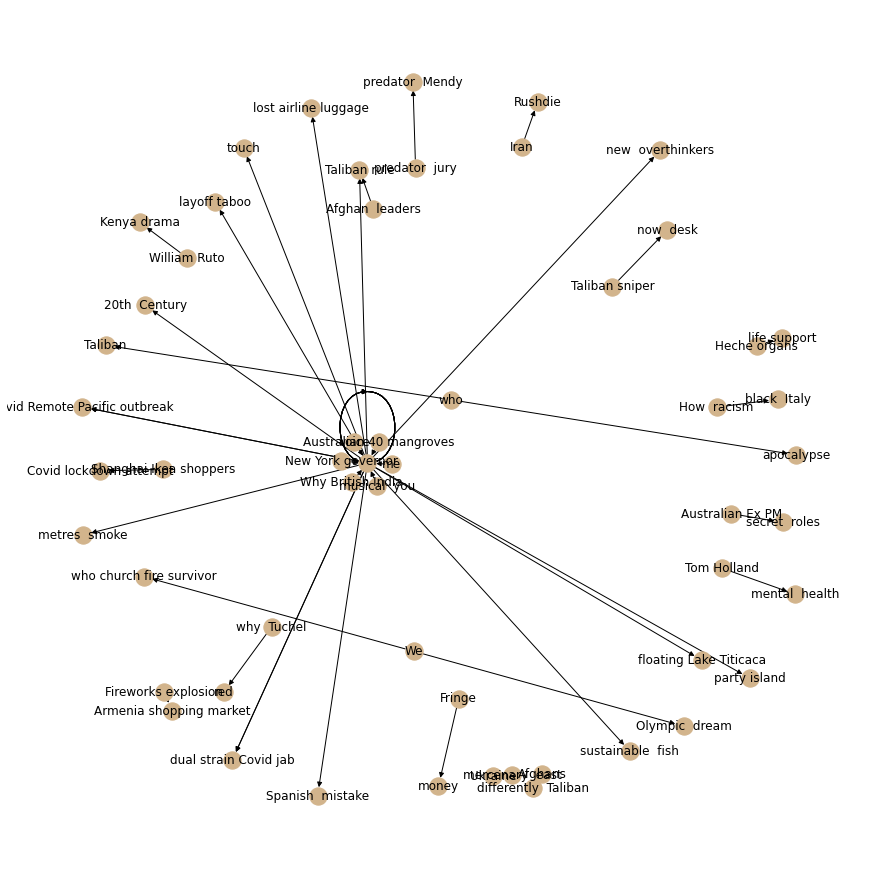

In [161]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='tan', edge_cmap=plt.cm.Greys, pos = pos)
plt.show()

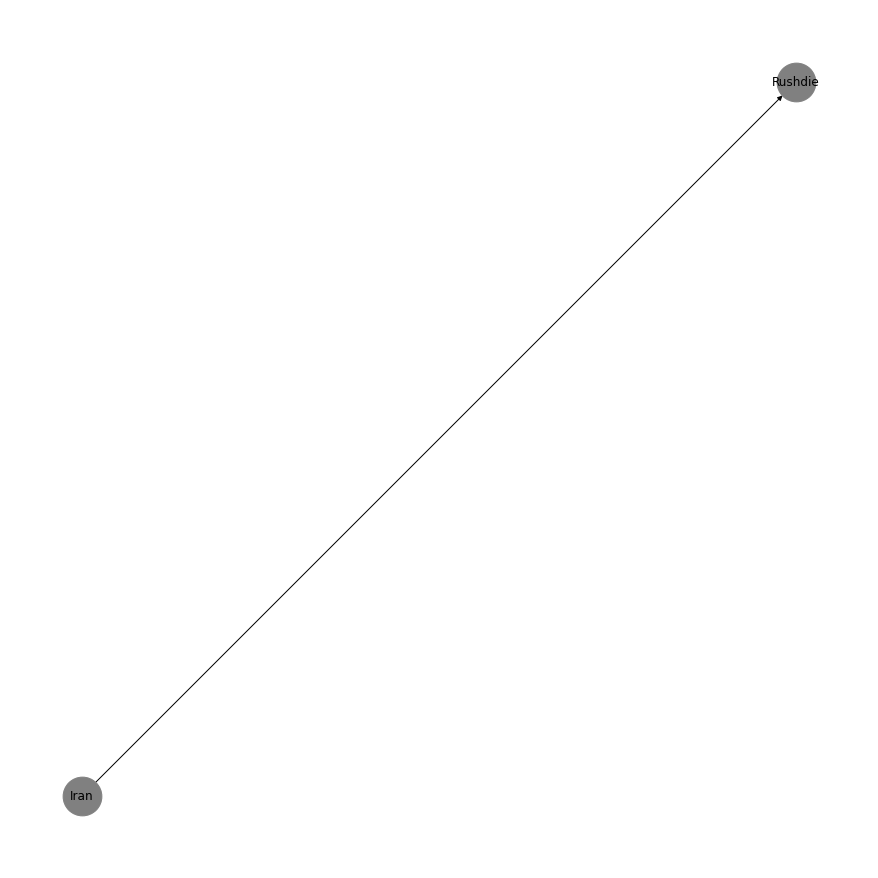

In [162]:
H=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="blames"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(H, k = 0.9) # k regulates the distance between nodes
nx.draw(H, with_labels=True, node_color='grey', node_size=1500, edge_cmap=plt.cm.Greys, pos = pos)
plt.show()

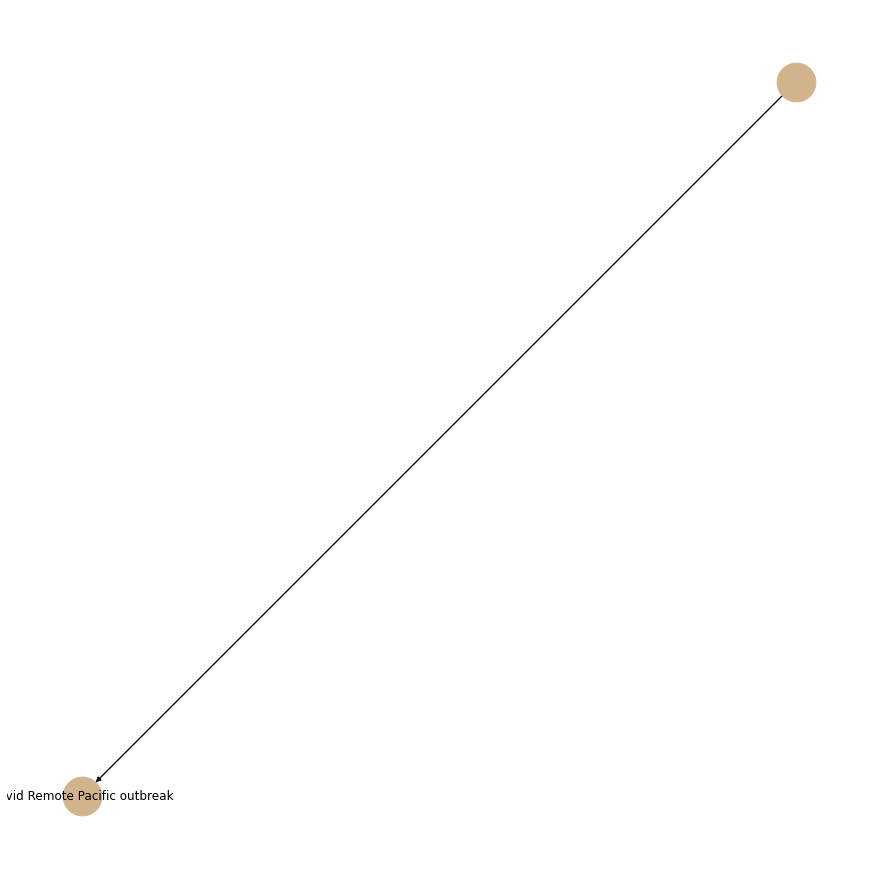

In [163]:
I=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="nation"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(I, k = 0.5)
nx.draw(I, with_labels=True, node_color='tan', node_size=1500, edge_cmap=plt.cm.Greys, pos = pos)
plt.show()

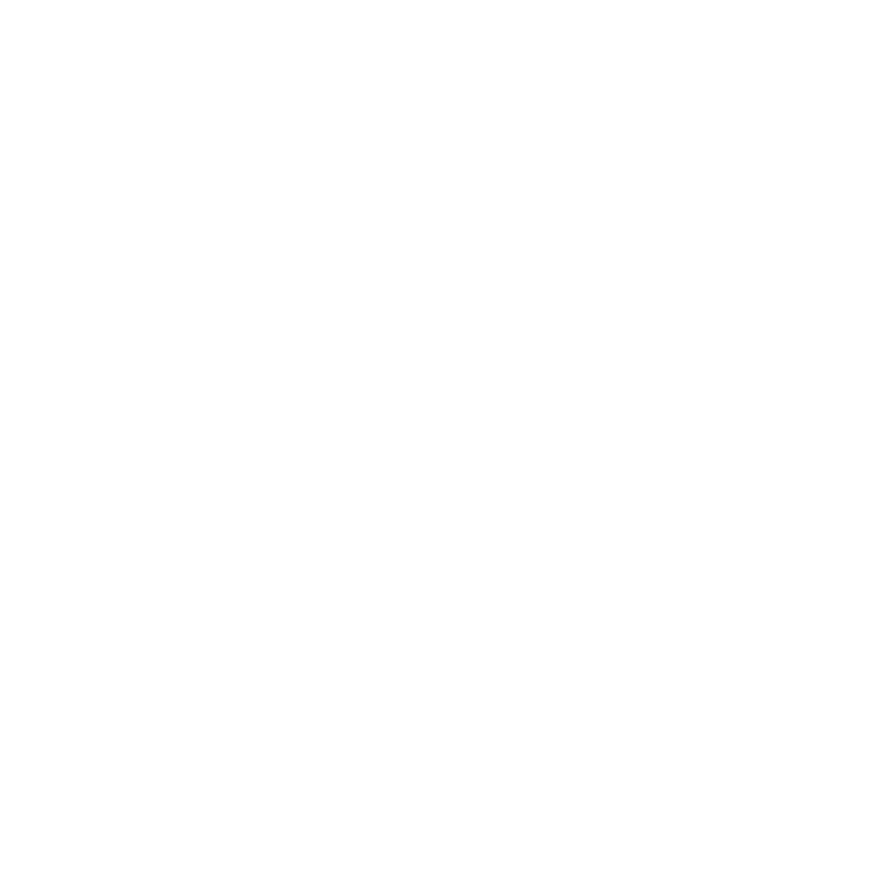

In [164]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="pull"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='silver', node_size=1500, edge_cmap=plt.cm.Greys, pos = pos)
plt.show()

In [ ]:
nltk.download('punkt')
text2 = "BBC News is an operational business division of the British Broadcasting Corporation (BBC) responsible for the gathering and broadcasting of news and current affairs in the UK and around the world. The department is the world's largest broadcast news organisation and generates about 120 hours of radio and television output each day, as well as online news coverage. The service maintains 50 foreign news bureaus with more than 250 correspondents around the world. Fran Unsworth has been director of news and current affairs since January 2018. In 2019, it was reported in an Ofcom report that the BBC spent £136m on news during the period April 2018 to March 2019. BBC News domestic, global and online news divisions are housed within the largest live newsroom in Europe, in Broadcasting House in central London. Parliamentary coverage is produced and broadcast from studios in London. Through BBC English Regions, the BBC also has regional centres across England and national news centres in Northern Ireland, Scotland and Wales. All nations and English regions produce their own local news programmes and other current affairs and sport programmes."
print(text2)

BBC News is an operational business division of the British Broadcasting Corporation (BBC) responsible for the gathering and broadcasting of news and current affairs in the UK and around the world. The department is the world's largest broadcast news organisation and generates about 120 hours of radio and television output each day, as well as online news coverage. The service maintains 50 foreign news bureaus with more than 250 correspondents around the world. Fran Unsworth has been director of news and current affairs since January 2018. In 2019, it was reported in an Ofcom report that the BBC spent £136m on news during the period April 2018 to March 2019. BBC News domestic, global and online news divisions are housed within the largest live newsroom in Europe, in Broadcasting House in central London. Parliamentary coverage is produced and broadcast from studios in London. Through BBC English Regions, the BBC also has regional centres across England and national news centres in North

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
sentences2 = nltk.sent_tokenize(text2)  
words2 = nltk.word_tokenize(text2)  

In [ ]:
sentences2

['BBC News is an operational business division of the British Broadcasting Corporation (BBC) responsible for the gathering and broadcasting of news and current affairs in the UK and around the world.',
 "The department is the world's largest broadcast news organisation and generates about 120 hours of radio and television output each day, as well as online news coverage.",
 'The service maintains 50 foreign news bureaus with more than 250 correspondents around the world.',
 'Fran Unsworth has been director of news and current affairs since January 2018.',
 'In 2019, it was reported in an Ofcom report that the BBC spent £136m on news during the period April 2018 to March 2019.',
 'BBC News domestic, global and online news divisions are housed within the largest live newsroom in Europe, in Broadcasting House in central London.',
 'Parliamentary coverage is produced and broadcast from studios in London.',
 'Through BBC English Regions, the BBC also has regional centres across England and 

In [ ]:
df2 = pd.DataFrame(sentences2)
df2.to_csv("s2.csv", index=False)

In [ ]:
pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 208 kB 14.9 MB/s 


In [ ]:
import PyPDF2

In [ ]:
pdfFileObj = open('Multilingual.pdf', 'rb') 
    
# creating a pdf reader object 
pdfReader = PyPDF2.PdfFileReader(pdfFileObj) 
    
# printing number of pages in pdf file 
print(pdfReader.numPages) 
    
# creating a page object 
pageObj = pdfReader.getPage(0) 

19


In [ ]:
# extracting text from pdf page 
print(pageObj.extractText()) 

Undeﬁned 0 (0) 1 1
IOS Press
Multilingual Linked Open Data Patterns
Jose Emilio Labra Gayoa;, Dimitris Kontokostasband Sören Auerb
aDepartment of Computer Science. University of Oviedo, CP. 33007, Oviedo, Spain
Email: labra@uniovi.es
bUniversität Leipzig, Institut für Informatik, AKSW, Postfach 100920, 04009 Leipzig, Germany
E-mail: {lastname}@informatik.uni-leipzig.de
Abstract. The increasing publication of linked data makes the vision of the semantic web a probable reality .
Although it may seem that the web of data is inherently multilingual, data usually contains labels, comments,
descriptions, etc. that depend on the natural language used. When linked data appears in a multilingual setting,
it is a challenge to publish and consume it. This paper presents a survey of patterns and best practices to publish
Multilingual Linked Data and identiﬁes some issues that should be taken into account. As a use case, the paper
describes the patterns employed in the DBpedia Internationalization

In [ ]:
# save text to object
a=pdfReader.getPage(2).extractText()

In [ ]:
a

'J. Labra et al / Multilingual LOD Patterns 3\nIn the case of the W eb architecture, the solution\nadopted was Normalization F orm Canonical Com-\nposition (NFC) and is described in [ 3]. The use of\nnormalization is important for linked data as it is\nnecessary to have a non-ambiguous way to check\nif two identiﬁers are the same.\n2.2. URIs and IRIs\nOne of the cornerstones of W eb architecture is\nthe use of Uniform Resource Identiﬁers (URIs) [ 8]\nto identify any kind of resource. URIs were for-\nmally described by the IETF RFC 3986 [ 11 ] and\ntheir design oﬀered a trade-oﬀ solution between\nreadability and usability .\nThe readability goal can be achieved when URIs\nare easily remembered and interpreted by people,\nemploying meaningful or familiar components. T o\nthat end, people from non-Latin alphabets should\nbe allowed to use their own alphabets (i.e. Unicode\ncharacters) in their URIs. However, due to the\nusability design trade-oﬀ, the URI speciﬁcation\nrestricted the chara

In [ ]:
# save tokenized sentences to object 
sentences3 = nltk.sent_tokenize(a) 

In [ ]:
sentences3

['J. Labra et al / Multilingual LOD Patterns 3\nIn the case of the W eb architecture, the solution\nadopted was Normalization F orm Canonical Com-\nposition (NFC) and is described in [ 3].',
 'The use of\nnormalization is important for linked data as it is\nnecessary to have a non-ambiguous way to check\nif two identiﬁers are the same.',
 '2.2.',
 'URIs and IRIs\nOne of the cornerstones of W eb architecture is\nthe use of Uniform Resource Identiﬁers (URIs) [ 8]\nto identify any kind of resource.',
 'URIs were for-\nmally described by the IETF RFC 3986 [ 11 ] and\ntheir design oﬀered a trade-oﬀ solution between\nreadability and usability .',
 'The readability goal can be achieved when URIs\nare easily remembered and interpreted by people,\nemploying meaningful or familiar components.',
 'T o\nthat end, people from non-Latin alphabets should\nbe allowed to use their own alphabets (i.e.',
 'Unicode\ncharacters) in their URIs.',
 'However, due to the\nusability design trade-oﬀ, the URI spe

In [ ]:
# convert tokenized object to dataframe
import pandas as pd
df3 = pd.DataFrame(sentences3)
df3.to_csv("sentences3.csv", index=False)

In [ ]:
# column name for sentence is 0
df3

In [ ]:
df2.shape

(9, 1)

In [ ]:
df3.shape

(38, 1)

In [ ]:
# exact sentence example
nlp = spacy.load('en_core_web_sm')

doc = nlp("The service maintains 50 foreign news bureaus with more than 250 correspondents around the world.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

The ... det
service ... nsubj
maintains ... ROOT
50 ... nummod
foreign ... amod
news ... compound
bureaus ... dobj
with ... prep
more ... amod
than ... quantmod
250 ... nummod
correspondents ... pobj
around ... prep
the ... det
world ... pobj
. ... punct


In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]
# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

ValueError: ignored

In [ ]:
kg_df.head()

,source,target,edge
0,Iran,Rushdie,blames
1,Iran,Rushdie,blames
2,,Taliban rule,Doucet
3,Afghans,differently Taliban,feel
4,Shanghai Ikea shoppers,Covid lockdown attempt,flee


In [ ]:
# the column name is 0
relations = [get_relation(i) for i in tqdm(df3['0'])]

KeyError: ignored

In [ ]:
entity_pairs = []

for i in tqdm(df3["0"]):
  entity_pairs.append(get_entities(i))

KeyError: ignored